In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-8au4ehgl
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-8au4ehgl
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 2042779efa3aa2ad48bcefad34076cc57c0b0620
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
print("this is hiw statsmodel installed")

In [2]:
!pip install --user --upgrade statsmodels

In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_squared_error
import pandas as pd
import os
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import time

In [6]:

from chronos import ChronosPipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [4]:
df_final = pd.read_csv('/content/drive/My Drive/df_final1.csv')


In [5]:
summed_df = df_final.groupby('squared_id')['internet_traffic'].sum().reset_index()
max_traffic_index = summed_df['internet_traffic'].idxmax()

# Extract the 'squared_id' with the highest total traffic
area_id_with_max_traffic = summed_df.loc[max_traffic_index, 'squared_id']

print("The squared_id with the highest total traffic is:", area_id_with_max_traffic)

The squared_id with the highest total traffic is: 5161


In [6]:
df_final['timeinterval'] = pd.to_datetime(df_final['timeinterval'])

In [10]:
def convert2timesries(my_dataframe):
    #my_dataframe1 = my_dataframe.copy()
    timeSeries = my_dataframe.loc[:, ["timeinterval","internet_traffic"]]
    timeSeries.index = timeSeries.timeinterval
    ts = timeSeries.drop("timeinterval",axis=1)
    return ts

In [11]:
def tr_test_split(mydata):
    training_start_date = datetime(2013, 11, 1) # Assuming the year is 2023
    training_end_date = datetime(2013,12,16)
    df_training = mydata[(mydata['timeinterval'] >= training_start_date) & (mydata['timeinterval'] < training_end_date)]
    df_training.reset_index(inplace=True)
    df_training = df_training.groupby(['timeinterval', 'squared_id']).agg({'internet_traffic': 'sum'}).reset_index()
    #df_training.set_index('timeinterval').resample('2s').sum().reset_index()


    test_start_date = datetime(2013, 12, 16) # Assuming the year is 2023
    test_end_date = datetime(2013,12,22)
    df_test = mydata[(mydata['timeinterval'] >= test_start_date) & (mydata['timeinterval'] < test_end_date)]
    df_test.reset_index(inplace=True)
    df_test = df_test.groupby(['timeinterval', 'squared_id']).agg({'internet_traffic': 'sum'}).reset_index()
    return df_training , df_test

In [12]:
def resampler(data, column):

    data[column] = pd.to_datetime(data[column])

    # Set 'timeinterval' as the index for ts_training_4159
    data.set_index(column, inplace=True)

    # Resample the data to every hour and calculate the mean
    df_resampled = data.resample('180min').mean()

    # Reset the index if you want 'timeinterval' back as a column
    df_resampled.reset_index(inplace=True)
    # Now 'timeinterval' is accessible as a column again
    df_resampled[column] = df_resampled[column].fillna(method='ffill')
    return df_resampled

In [13]:
df_4556 = df_final[df_final['squared_id'] == 4556]
df_5161= df_final[df_final['squared_id'] == area_id_with_max_traffic]
df_4159 = df_final[df_final['squared_id'] == 4159]

In [14]:
tr_4556 ,test_4556 = tr_test_split(df_4556)
tr_5161 ,test_5161 = tr_test_split(df_5161)
tr_4159 ,test_4159 = tr_test_split(df_4159)

In [15]:
ts_training_4556 = resampler(tr_4556 , 'timeinterval')
ts_training_4556 = convert2timesries(ts_training_4556)


In [16]:
ts_test_4556 = resampler(test_4556, 'timeinterval')
ts_test_4556 = convert2timesries(ts_test_4556)

In [17]:
ts_training_4159 = resampler(tr_4159 , 'timeinterval')
ts_training_4159 = convert2timesries(ts_training_4159)
ts_test_4159 = resampler(test_4159, 'timeinterval')
ts_test_4159 = convert2timesries(ts_test_4159)


In [18]:

ts_training_5161 = resampler(tr_5161 , 'timeinterval')
ts_training_5161 = convert2timesries(ts_training_5161)
ts_test_5161 = resampler(test_5161, 'timeinterval')
ts_test_5161 = convert2timesries(ts_test_5161)


In [19]:
context1 = torch.tensor(ts_training_4556["internet_traffic"]) ## for predicting city with idea 4556
context2 = torch.tensor(ts_training_4159["internet_traffic"]) ## for predicting city with idea 4159
context3 = torch.tensor(ts_training_5161["internet_traffic"]) ## for predicting city with the highest traffic



In [20]:
def caculate_mae_mape(predicted, test_data):
  absolute_differences = np.abs(predicted - test_data["internet_traffic"])
  # Calculate the mean of these absolute differences
  mae = np.mean(absolute_differences)
  percentage_differences = np.abs((predicted - test_data["internet_traffic"]) / test_data["internet_traffic"]) * 100
  # Calculate the mean of these percentage differences
  mape = np.mean(percentage_differences)
  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

  return mae ,mape


In [21]:
def plot_predicted_traffic(forcast, ts_test,ts_train):
  start_date = ts_train.index[-1]
  median = 0
  # Step 2: Calculate the timestamps for each forecast index
  # Assuming your forecast data is 10 minutes apart
  forecast_timestamps = pd.date_range(start=start_date, periods=prediction_length, freq='3h')

  # Step 3: Plot using the forecast timestamps
  low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
  caculate_mae_mape(median, ts_test)
  plt.figure(figsize=(20, 8))

  plt.plot(forecast_timestamps,ts_test["internet_traffic"], color="royalblue", label="historical data")
  plt.plot(forecast_timestamps, median, color="tomato", label="median forecast")
  plt.legend()
  plt.grid()
  plt.show()


In [22]:
prediction_length = 48
forecast = pipeline.predict(
    context3,
    prediction_length,
    num_samples=200,
    temperature=0.5,
    top_k=250,
    top_p=1.0,
) # forecast shape: [num_series, num_samples, prediction_length]

Mean Absolute Error (MAE): 99.64586915252796
Mean Absolute Percentage Error (MAPE): 21.573738507860767%


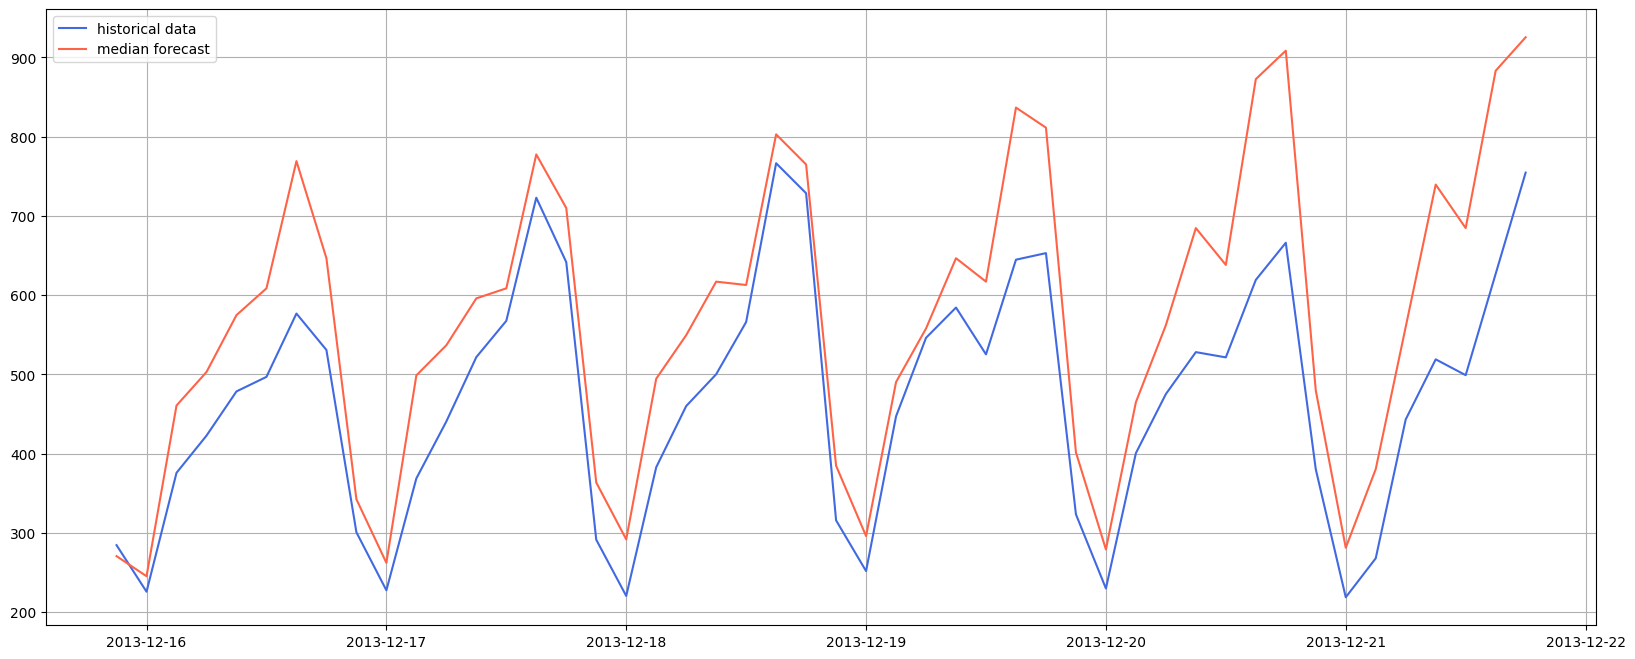

In [ ]:
plot_predicted_traffic(forecast,ts_test_4556,ts_training_4556)

Mean Absolute Error (MAE): 79.80892358165077
Mean Absolute Percentage Error (MAPE): 28.29654624811256%


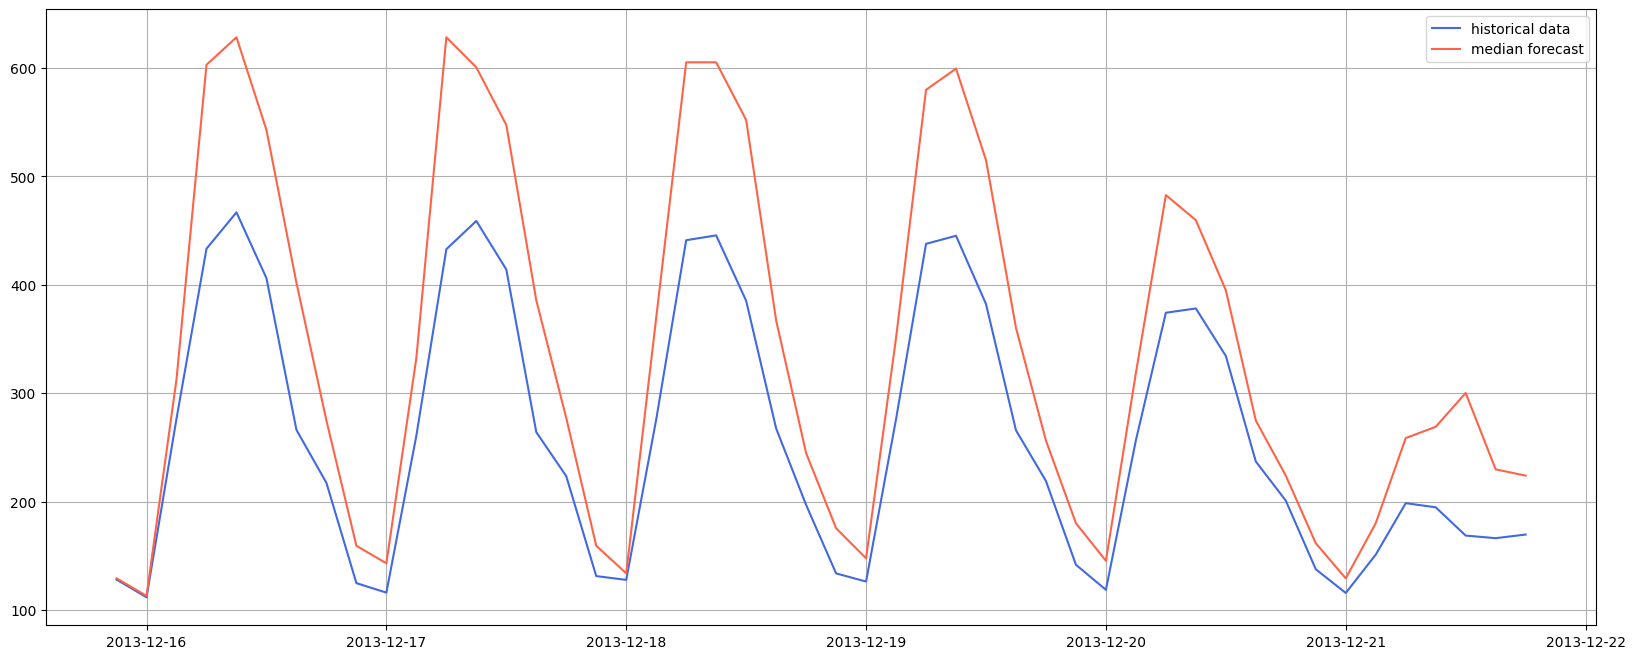

In [ ]:
plot_predicted_traffic(forecast,ts_test_4159,ts_training_4159)

Mean Absolute Error (MAE): 315.21048276994526
Mean Absolute Percentage Error (MAPE): 26.67210434479617%


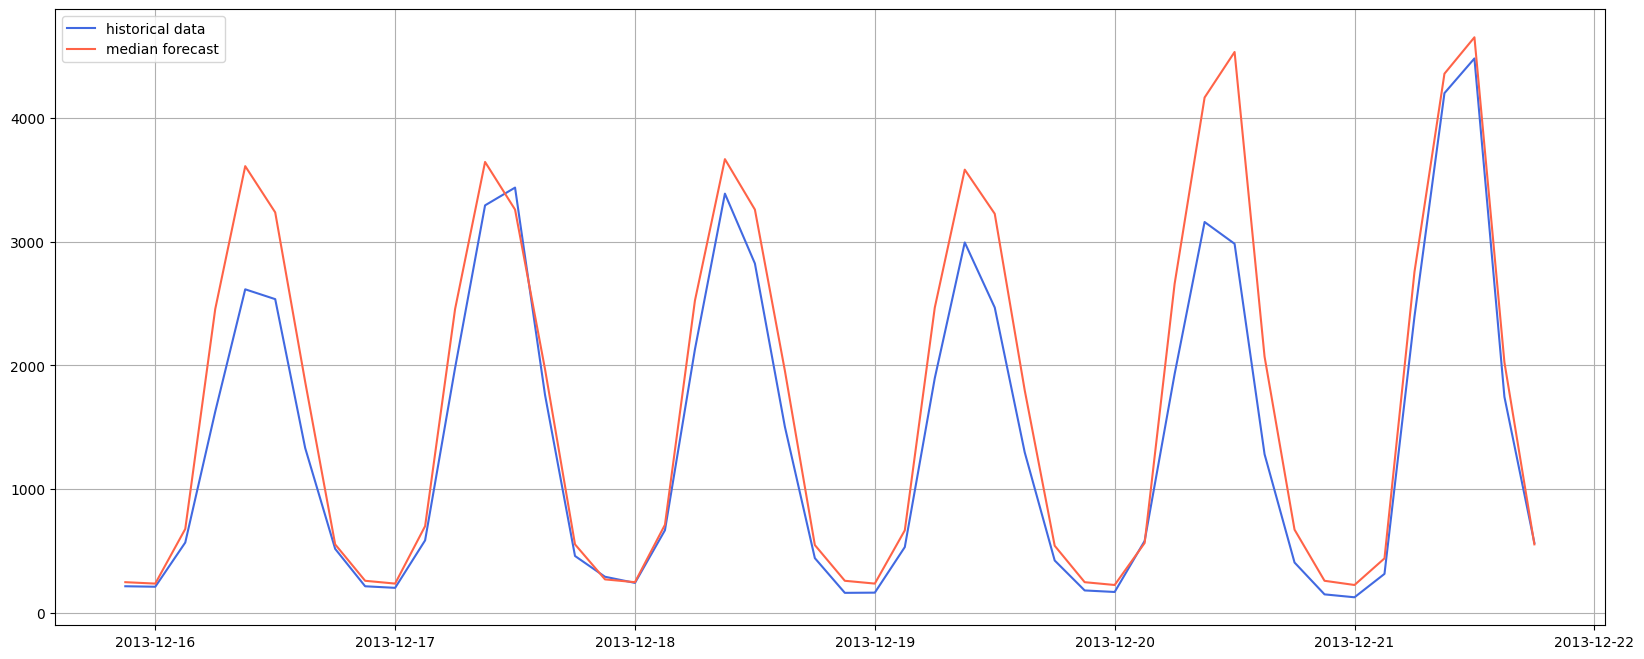

In [23]:
plot_predicted_traffic(forecast,ts_test_5161,ts_training_5161)